# Lesson 1 - What's your ~~pet~~ copter doing?

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [18]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [4]:
np.random.seed(2)


In [5]:
path = Path('/home/ubuntu/data/choppers/')

In [9]:
path.ls()

[PosixPath('/home/ubuntu/data/choppers/1'),
 PosixPath('/home/ubuntu/data/choppers/0')]

In [36]:
tfms = None

# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=600)

# ^^ That assumes the train/valid split has already been done and in folders.
# So I modified it using the data_block api https://docs.fast.ai/data_block.html

np.random.seed(2) # ensures the same validation set every time, so can compare changes 

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=600)       #Data augmentation? -> use tfms with a size of 600, because they all are
        .databunch(bs=16))

### Here's another way to do the same thing:

# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


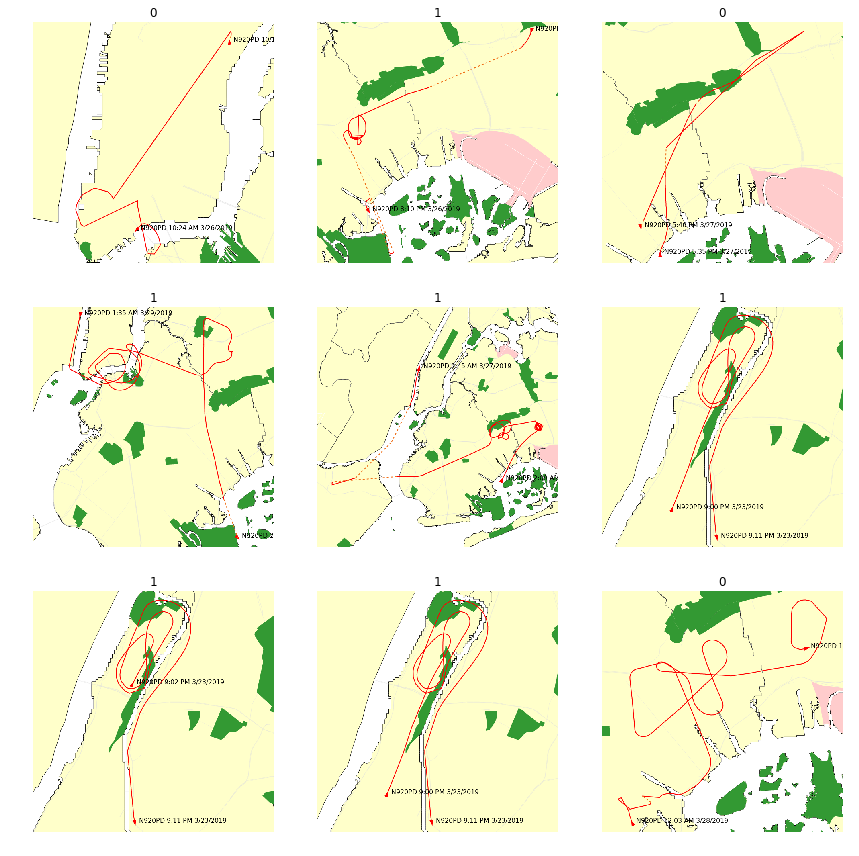

In [37]:
data.show_batch(rows=3)

In [38]:
print(data.classes)
len(data.classes),data.c

['0', '1']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [69]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [70]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [41]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.840955,0.591355,0.361111,00:14
1,0.669893,0.526911,0.277778,00:09
2,0.525432,0.506458,0.250000,00:09
3,0.422191,0.414355,0.222222,00:09
4,0.345949,0.274742,0.138889,00:09
5,0.285244,0.265490,0.111111,00:09


In [42]:
learn.save('copters-stage-3') #stage-3 has .11 error rate

In [50]:
data

ImageDataBunch;

Train: LabelList (147 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
1,1,1,1,1
Path: /home/ubuntu/data/choppers;

Valid: LabelList (36 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,1,1,0
Path: /home/ubuntu/data/choppers;

Test: None

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

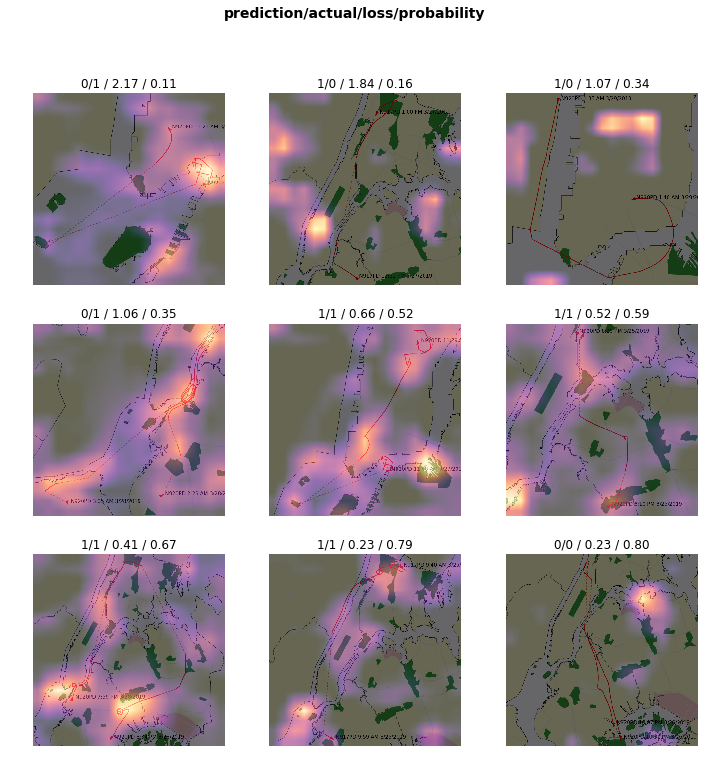

In [52]:
interp.plot_top_losses(9)

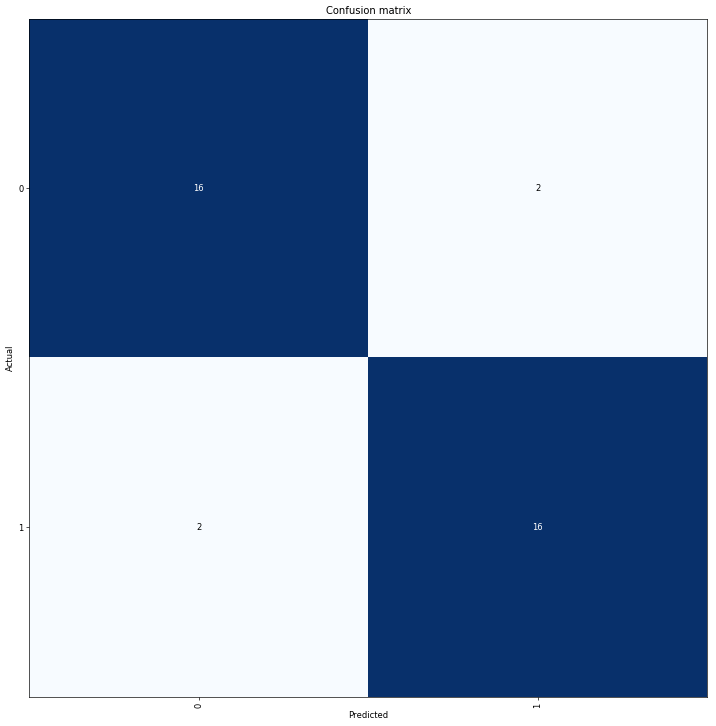

In [46]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [47]:
interp.most_confused(min_val=2)

[('0', '1', 2), ('1', '0', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [53]:
learn.unfreeze()

In [54]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.484303,1.150659,0.250000,00:13


That actually didn't help. So loading back the original model.

In [77]:
learn.load('copters-stage-3');

In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


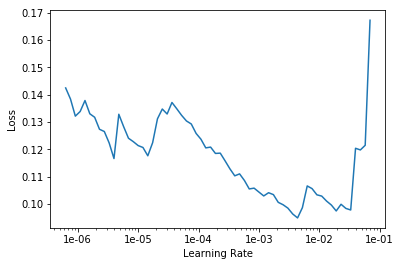

In [73]:
learn.recorder.plot()

In [78]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.283528,0.435276,0.111111,00:12
1,0.270922,0.240978,0.111111,00:12


In [79]:
# Commenting out so I don't accidentally run this again

learn.save('copters-stage-4') # copters-stage-4 has 0.11 error rate

## Doing this in production

In [80]:
data.classes

['0', '1']

In [81]:
learn.load('copters-stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (147 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
1,1,1,1,1
Path: /home/ubuntu/data/choppers;

Valid: LabelList (36 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,1,1,0
Path: /home/ubuntu/data/choppers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [82]:
learn.export()  #this creates a pickle file with all the info we need

In [83]:
defaults.device = torch.device('cpu')


In [84]:
img = open_image('/home/ubuntu/data/newimages/N917PD2019-04-02_09_50_09.png')

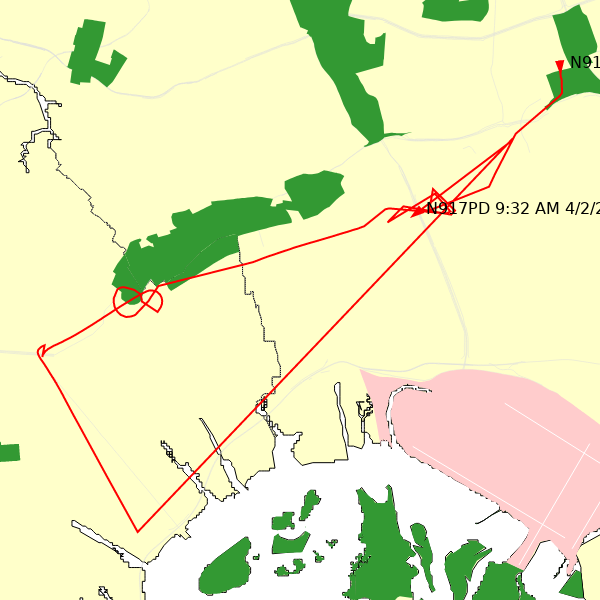

In [85]:
img

In [86]:
learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [87]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 1